# RandomForestRegressor Con series Temporales
* No tienen en cuenta las horas anterirores.
### (TimeSeriesSplit)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
%matplotlib inline

url ="https://raw.githubusercontent.com/albercol/TFG/main/Fase2/Fase%202.3/DatosUnificados/Cont_Meteo_Traf.csv"
df = pd.read_csv(url,parse_dates=['FECHAH'])
#df["HORA"] = df['FECHAH'].dt.hour ##Añadido
#df["DIA"] = df['FECHAH'].dt.day ##Añadido
#df["MES"] = df['FECHAH'].dt.month ##Añadido
df = df.dropna()

#Transformamos la columna tipo en 3 columnas numericas para cada tipo (LABORABLE, SABADO, DOMINGO, FESTIVO)
valores = df.TIPO.unique()
for v in valores:
    print(v)
    df[v] = df.TIPO.apply(lambda x: 1 if x==v else 0)

#Borramos las columnas que no son necesarias.
df = df.drop(['TIPO', 'NO', 'PM10', 'NOx'], axis=1)
df=df.set_index(['FECHAH'])
df.dropna(inplace=True)
df

LABORABLE
SABADO
DOMINGO
FESTIVO


,CO,NO2,PM2.5,O3,VELOCIDAD VIENTO,DIR. VIENTO,TEMPERATURA,HUMEDAD RELATIVA,PRESION BAROMETRICA,PRECIPITACIONES,ES10,ES53,ESSUMA,LABORABLE,SABADO,DOMINGO,FESTIVO
FECHAH,,,,,,,,,,,,,,,,,
2019-08-01 00:00:00,0.2,22.0,10.0,58.87,1.84,97.0,26.1,52.0,943.0,0.0,223.0,347.0,570.0,1,0,0,0
2019-08-01 01:00:00,0.2,15.0,10.0,63.73,1.97,117.0,24.9,55.0,943.0,0.0,173.0,231.0,404.0,1,0,0,0
2019-08-01 02:00:00,0.1,14.0,9.0,66.50,1.72,96.0,24.0,55.0,943.0,0.0,107.0,180.0,287.0,1,0,0,0
2019-08-01 03:00:00,0.1,14.0,10.0,66.62,1.55,106.0,23.3,55.0,943.0,0.0,80.0,129.0,209.0,1,0,0,0
2019-08-01 04:00:00,0.2,15.0,10.0,62.57,1.13,67.0,22.9,57.0,943.0,0.0,89.0,105.0,194.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-25 10:00:00,0.3,38.0,9.0,47.20,1.37,79.0,18.3,46.0,953.0,0.0,587.0,658.0,1245.0,1,0,0,0
2021-05-25 11:00:00,0.3,37.0,7.0,60.22,1.93,62.0,19.3,42.0,953.0,0.0,582.0,651.0,1233.0,1,0,0,0
2021-05-25 12:00:00,0.2,31.0,7.0,73.93,1.53,12.0,21.2,38.0,952.0,0.0,573.0,743.0,1316.0,1,0,0,0


In [2]:
def split_test(df,  predict, horas, hAnterior):
    colsX = [ 'VELOCIDAD VIENTO', 'DIR. VIENTO', 'TEMPERATURA', 'HUMEDAD RELATIVA',
           'PRESION BAROMETRICA', 'PRECIPITACIONES', 'ES10','ES53','ESSUMA' ,"LABORABLE",
             "SABADO","DOMINGO", "FESTIVO"]
     
    #Se le añade el valor predicho del la hora anterior.
    if hAnterior:
        colsX.append("pred")
        #Añadimos la columna con la prediccion de la hora anterior
        df["pred"] = df[predict].shift(+1)
        df = df[1:]
    
    X = df[colsX].values
    y = df[predict].values
    
    test, pred = [ [] for i in range(horas)], [ [] for i in range(horas)]
    
    n_splits = 15
    splits = TimeSeriesSplit(n_splits=n_splits, test_size=horas) #testsize=8 porque queremos predecir a 8 horas futuras.
    model = RandomForestRegressor()
    print(splits)

    for step, (train_index, test_index) in enumerate(splits.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if len(predict) == 1: 
            y_train = y_train.ravel()
            
        #entrenamos el modelo
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        for i in range(horas):
            test[i].append(y_test[i])
            pred[i].append(y_pred[i])
        
        
    return test, pred


In [3]:
def printGrafError(maes, cont, horas):
    # Declaramos valores para el eje x
    horasPred = [('t+%s' %(i+1)) for i in range(horas)]
    
    plt.bar(horasPred, maes, color="red", alpha=0.30)
    plt.ylabel('Nivel de error')
    plt.xlabel('Predicciones')
    plt.title('Degradación de la predicción para '+ cont)
    plt.show()

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=15, test_size=8)


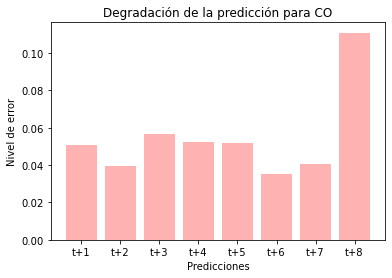

[0.05059999999999995, 0.03926666666666669, 0.05666666666666674, 0.05253333333333332, 0.05193333333333332, 0.03526666666666665, 0.04046666666666676, 0.11086666666666666]
TimeSeriesSplit(gap=0, max_train_size=None, n_splits=15, test_size=8)


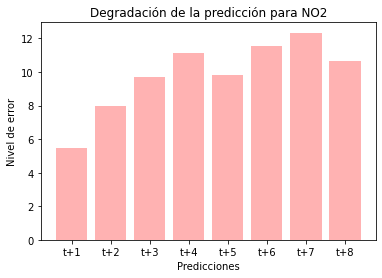

[5.450666666666667, 7.961333333333332, 9.726666666666667, 11.132666666666667, 9.800666666666666, 11.562666666666667, 12.338, 10.65]
TimeSeriesSplit(gap=0, max_train_size=None, n_splits=15, test_size=8)


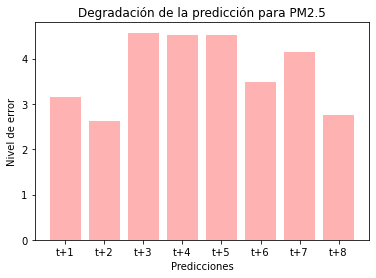

[3.162000000000001, 2.6213333333333337, 4.572666666666666, 4.516000000000001, 4.5326666666666675, 3.4926666666666657, 4.141333333333334, 2.7493333333333334]
TimeSeriesSplit(gap=0, max_train_size=None, n_splits=15, test_size=8)


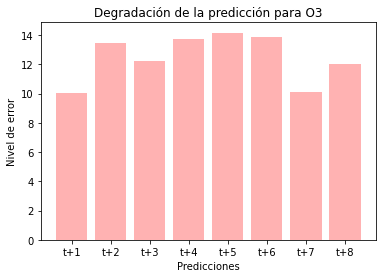

[10.033906666666665, 13.451433333333323, 12.197739999999989, 13.698000000000002, 14.156519999999997, 13.853053333333339, 10.112113333333335, 11.996113333333332]


In [4]:
#Predecimos a 8 horas futuras.
horas = 8

colContaminantes = ["CO","NO2", "PM2.5", "O3"]
for i in range(len(colContaminantes)) :
    maes = []
    #Se ha añadido la prediccion de la hora anterior
    test, pred = split_test(df, colContaminantes[i], horas, False)
    maes=[mean_absolute_error(test[j],pred[j]) for j in range(horas)]
    printGrafError(maes, colContaminantes[i], horas)
    print(maes)